In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json
from tqdm import tqdm

In [2]:
inDIR = './cnn_test_results_2cm/'
model_prefix = 'deeplabplus_*'

In [3]:
for idx, d in enumerate(glob.glob(os.path.join(inDIR, model_prefix))):
    inputs_tmp = '_'.join(os.path.basename(d).split('_')[1:])
    if idx == 0:
        df_bbox_gt = pd.read_csv(os.path.join(d, 'test_valid_bbox_gt.csv'))
        
        with open(os.path.join(d, 'test_valid_burrow.json'), 'r') as src:
            burrow_valid = json.load(src)
            burrow_valid['inputs'] = '_'.join(burrow_valid['inputs'])
            df_valid_burrow = pd.DataFrame(burrow_valid, index=[idx])
        
        with open(os.path.join(d, 'test_valid_pixel.json'), 'r') as src:
            pixel_valid = json.load(src)
            pixel_valid['inputs'] = '_'.join(pixel_valid['inputs'])
            df_valid_pixel = pd.DataFrame(pixel_valid, index=[idx])
            
        df_burrow_gt = pd.read_csv(os.path.join(d, 'test_valid_burrow_gt.csv'))
        df_burrow_ct = pd.read_csv(os.path.join(d, 'test_valid_burrow_count.csv'))
        df_burrow_ct.insert(0, 'inputs', inputs_tmp)
            
    else:
        df_bbox_gt_tmp = pd.read_csv(os.path.join(d, 'test_valid_bbox_gt.csv'))
        df_bbox_gt = pd.concat([df_bbox_gt, df_bbox_gt_tmp])
        
        with open(os.path.join(d, 'test_valid_burrow.json'), 'r') as src:
            burrow_valid = json.load(src)
            burrow_valid['inputs'] = '_'.join(burrow_valid['inputs'])
            df_valid_burrow_tmp = pd.DataFrame(burrow_valid, index=[idx])
            df_valid_burrow = pd.concat([df_valid_burrow, df_valid_burrow_tmp])
        
        with open(os.path.join(d, 'test_valid_pixel.json'), 'r') as src:
            pixel_valid = json.load(src)
            pixel_valid['inputs'] = '_'.join(pixel_valid['inputs'])
            df_valid_pixel_tmp = pd.DataFrame(pixel_valid, index=[idx])
            df_valid_pixel = pd.concat([df_valid_pixel, df_valid_pixel_tmp])
            
        df_burrow_gt_tmp = pd.read_csv(os.path.join(d, 'test_valid_burrow_gt.csv'))
        df_burrow_gt = pd.concat([df_burrow_gt, df_burrow_gt_tmp])
        
        df_burrow_ct_tmp = pd.read_csv(os.path.join(d, 'test_valid_burrow_count.csv'))
        df_burrow_ct_tmp.insert(0, 'inputs', inputs_tmp)
        df_burrow_ct = pd.concat([df_burrow_ct, df_burrow_ct_tmp])

In [4]:
df_valid_pixel = df_valid_pixel[['model', 'inputs', 'accuracy', 'precision', 'recall', 'fscore']]
df_valid_pixel.insert(2, 'n_inputs', df_valid_pixel['inputs'].apply(lambda x: len(x.split('_'))))
df_valid_burrow.insert(2, 'n_inputs', df_valid_burrow['inputs'].apply(lambda x: len(x.split('_'))))
df_burrow_ct.insert(1, 'n_inputs', df_burrow_ct['inputs'].apply(lambda x: len(x.split('_'))))

In [5]:
# subset results to only the combos to be evaluated
#input_list = ['rgb', # RGB only
#              'rgb_ndvi', # RGB+Mutli-spectral
#              'dsm_tpi', # DSM only
#              'rgb_dsm_tpi', # RGB+DSM
#              'rgb_dsm_ndvi_tpi', # RGB+DSM+Multi-spectral
#             ]
#df_valid_pixel = df_valid_pixel[df_valid_pixel['inputs'].isin(input_list)] 
#df_valid_burrow = df_valid_burrow[df_valid_burrow['inputs'].isin(input_list)] 
#df_burrow_ct = df_burrow_ct[df_burrow_ct['inputs'].isin(input_list)] 
#df_burrow_gt = df_burrow_gt[df_burrow_gt['inputs'].isin(input_list)] 
#df_bbox_gt = df_bbox_gt[df_bbox_gt['inputs'].isin(input_list)] 

In [6]:
df_valid_pixel.sort_values(['n_inputs', 'inputs']).round(2).drop(columns=['model'])

,inputs,n_inputs,accuracy,precision,recall,fscore
1,rgb,1,0.99,0.81,0.75,0.67
0,dsm_tpi,2,0.99,0.89,0.72,0.71
2,rgb_dsm,2,0.99,0.85,0.80,0.76
4,rgb_ndvi,2,0.99,0.86,0.75,0.71
3,rgb_dsm_ndvi,3,0.99,0.88,0.77,0.75


In [7]:
df_valid_burrow.sort_values(['n_inputs', 'inputs']).round(2).drop(columns=['model'])

,inputs,n_inputs,precision,recall,fscore,corr
1,rgb,1,0.71,0.68,0.69,0.81
0,dsm_tpi,2,0.84,0.70,0.77,0.87
2,rgb_dsm,2,0.84,0.85,0.85,0.96
4,rgb_ndvi,2,0.77,0.64,0.70,0.86
3,rgb_dsm_ndvi,3,0.85,0.74,0.79,0.92


In [8]:
import scipy as sp
sns.set(font_scale = 1.3)
sns.set_style("ticks")
g = sns.lmplot(x='burrow_ct_gt', y='burrow_ct_pred', data=df_burrow_ct.sort_values(['n_inputs', 'inputs']),
               col='inputs', col_wrap=3, 
               scatter_kws={'color': 'black', 's': 10},
               line_kws={'color': 'black', 'linestyle': 'solid', 'linewidth': 1})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['burrow_ct_gt'], data['burrow_ct_pred'])
    mpe = np.mean((data['burrow_ct_pred'] - data['burrow_ct_gt']) / (data['burrow_ct_gt'].apply(lambda x: max(1, x))))
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    ax.text(.05, .74, 'MPE={:.2f}'.format(mpe),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
for ax in g.axes:
    ax.plot(np.arange(0, 20), np.arange(0, 20), c='black', linestyle='dashed', linewidth=1)
    ax.set_ylabel('Burrow count (predicted)')
    ax.set_xlabel('Burrow count (observed)')
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_yticks(np.arange(0, 21, 5))

plt.savefig('./results_figs/burrow_ct_corr.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.close()

In [9]:
df_burrow_gt['n_inputs'] = df_burrow_gt['inputs'].apply(lambda x: len(x.split('_')))

In [10]:
len(df_bbox_gt.Tile.unique())

67

In [11]:
len(df_burrow_gt[df_burrow_gt['is_burrow'] == 1].geometry.unique())

282

In [12]:
len(df_burrow_gt[(df_burrow_gt['is_burrow'] == 1) & (df_burrow_gt['activity'] > 0)].geometry.unique())

218

In [13]:
df_burrow_gt_recall = df_burrow_gt.groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['is_burrow'] == 1).sum())

df_burrow_gt_recall.name = 'Recall'
df_burrow_gt_precision = df_burrow_gt.groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['pred'] == 1).sum())

df_burrow_gt_precision.name = 'Precision'
df_burrow_gt_recall_a0 = df_burrow_gt[df_burrow_gt['activity'] != 0].groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['is_burrow'] == 1).sum())#.reset_index(level).rename(columns={0: 'Recall'})

df_burrow_gt_recall_a0.name = 'Recall active'
df_burrow_gt_precision_a0 = df_burrow_gt[df_burrow_gt['activity'] != 0].groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['pred'] == 1).sum())#.reset_index(level).rename(columns={0: 'Recall'})

df_burrow_gt_precision_a0.name = 'Precision active'

In [14]:
df_burrow_gt_smry = pd.merge(df_burrow_gt_precision, pd.merge(df_burrow_gt_recall,
                                       pd.merge(df_burrow_gt_precision_a0, df_burrow_gt_recall_a0, left_index=True, right_index=True),
                                       left_index=True, right_index=True),
         left_index=True, right_index=True).sort_values(['n_inputs', 'inputs'])
df_burrow_gt_smry.insert(2, 'F-score', (2 * df_burrow_gt_smry['Recall'] * df_burrow_gt_smry['Precision']) / (df_burrow_gt_smry['Recall'] + df_burrow_gt_smry['Precision']))
df_burrow_gt_smry['F-score active'] = (2 * df_burrow_gt_smry['Recall active'] * df_burrow_gt_smry['Precision active']) / \
                         (df_burrow_gt_smry['Recall active'] + df_burrow_gt_smry['Precision active'])

In [15]:
df_burrow_gt_smry.round(2)

,,Precision,Recall,F-score,Precision active,Recall active,F-score active
inputs,n_inputs,,,,,,
rgb,1,0.86,0.56,0.68,0.85,0.64,0.73
dsm_tpi,2,0.93,0.60,0.73,0.92,0.63,0.75
rgb_dsm,2,0.94,0.69,0.79,0.93,0.74,0.82
rgb_ndvi,2,0.91,0.52,0.66,0.90,0.60,0.72
rgb_dsm_ndvi,3,0.96,0.62,0.75,0.95,0.66,0.78


In [16]:
df_burrow_gt_error = df_burrow_gt.groupby(['n_inputs', 'inputs']).apply(lambda x: ((x['is_burrow'] == 0) & (x['pred'] == 1)).sum() / (x['pred'] == 1).sum())
df_burrow_gt_error.name = 'Error rate'
df_burrow_gt_error = df_burrow_gt_error.reset_index().sort_values(['n_inputs', 'inputs'])
df_burrow_gt_error['Comment'] = 'Overall'
df_burrow_gt_error = pd.pivot(df_burrow_gt_error, index='Comment', columns=['n_inputs', 'inputs'], values='Error rate')
df_burrow_gt_error = df_burrow_gt_error.droplevel(0, axis=1)

In [17]:
df_burrow_gt_nb_error = df_burrow_gt[df_burrow_gt['is_burrow'] == 0].groupby(['inputs', 
                                                                              'n_inputs', 
                                                                              'Comment']).apply(lambda x: ((x['pred'] == 1)).sum() / len(x['pred']))
df_burrow_gt_nb_error.name = 'Error rate'
df_burrow_gt_nb_error = df_burrow_gt_nb_error.reset_index().sort_values(['n_inputs', 'inputs'])
df_burrow_gt_nb_error = pd.pivot(df_burrow_gt_nb_error, index='Comment', columns=['n_inputs', 'inputs'], values='Error rate')
df_burrow_gt_nb_error = df_burrow_gt_nb_error.droplevel(0, axis=1)
df_burrow_gt_nb_error.insert(0, 'n', df_burrow_gt[df_burrow_gt['is_burrow'] == 0]['Comment'].value_counts() // len(df_burrow_gt['inputs'].unique()))

In [18]:
df_burrow_gt_error.insert(0, 'n', df_burrow_gt_nb_error['n'].sum())

In [19]:
df_error_fnl = pd.concat([df_burrow_gt_nb_error, df_burrow_gt_error]).round(2)
df_error_fnl

inputs,n,rgb,dsm_tpi,rgb_dsm,rgb_ndvi,rgb_dsm_ndvi
Comment,,,,,,
ant,67,0.28,0.03,0.06,0.12,0.01
den,8,0.38,0.25,0.38,0.38,0.38
dig,6,0.17,0.17,0.17,0.33,0.17
old,27,0.07,0.26,0.19,0.04,0.11
Overall,108,0.14,0.07,0.06,0.09,0.04


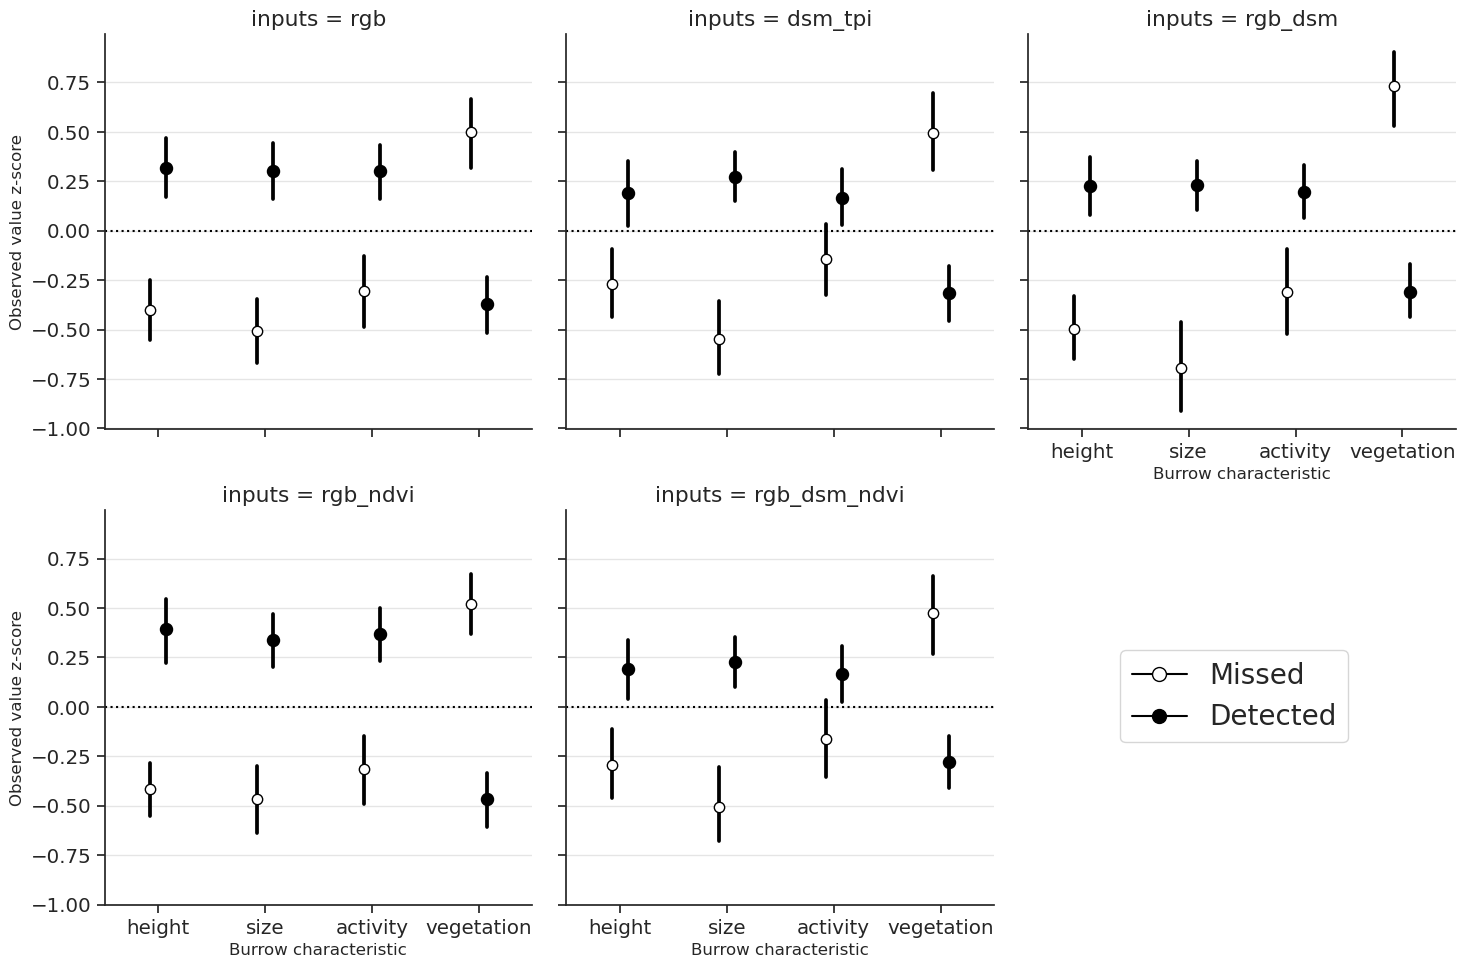

In [20]:
plt.close()
from matplotlib.lines import Line2D
from scipy import stats
sns.set(font_scale = 1.3)
sns.set_style("ticks")
df_burrow_gt_std = df_burrow_gt[df_burrow_gt['is_burrow'] == 1].copy()
df_burrow_gt_std['height'] = stats.zscore(df_burrow_gt_std['height'])
df_burrow_gt_std['size'] = stats.zscore(df_burrow_gt_std['size'])
df_burrow_gt_std['activity'] = stats.zscore(df_burrow_gt_std['activity'])
df_burrow_gt_std['vegetation'] = stats.zscore(df_burrow_gt_std['vegetation'])
df_burrow_gt_long = pd.melt(df_burrow_gt_std,
                               id_vars=['n_inputs', 'inputs', 'Pasture', 'is_burrow', 'pred', 'label'],
                               value_vars=['height', 'size', 'activity', 'vegetation'])
#df_burrow_gt_long.loc[df_burrow_gt_long['variable'] == 'vegetation', 'value'] = 3.0 - df_burrow_gt_long.loc[df_burrow_gt_long['variable'] == 'vegetation', 'value']
g=sns.catplot(x='variable', y='value', data=df_burrow_gt_long.sort_values(['n_inputs', 'inputs']), kind='point',
                hue='pred', col='inputs', col_wrap=3,
                join=False, dodge=0.15, markers='o', scale=1.1, 
              palette={0.0: 'black', 1.0: 'black'}, ec=['black', 'none'], legend=False)
for ax in g.axes:
    #ax.set_ylim(0, 3)
    ax.legend().remove()
    p1=ax.get_children()[4]
    p1.set_facecolor('white')
    p1.set_linewidth(1)
    ax.set_xlabel('Burrow characteristic', fontsize=12)
    ax.set_ylabel('Observed value z-score', fontsize=12)
    ax.axhline(y=0, linestyle='dotted', color='black')
    ax.grid(True, axis='y', alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='black', label='Missed',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]

g.fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.75, 0.0, 0.25, 0.35), fontsize=20)
plt.savefig('./results_figs/missed_burrow_characteristics_zscore.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

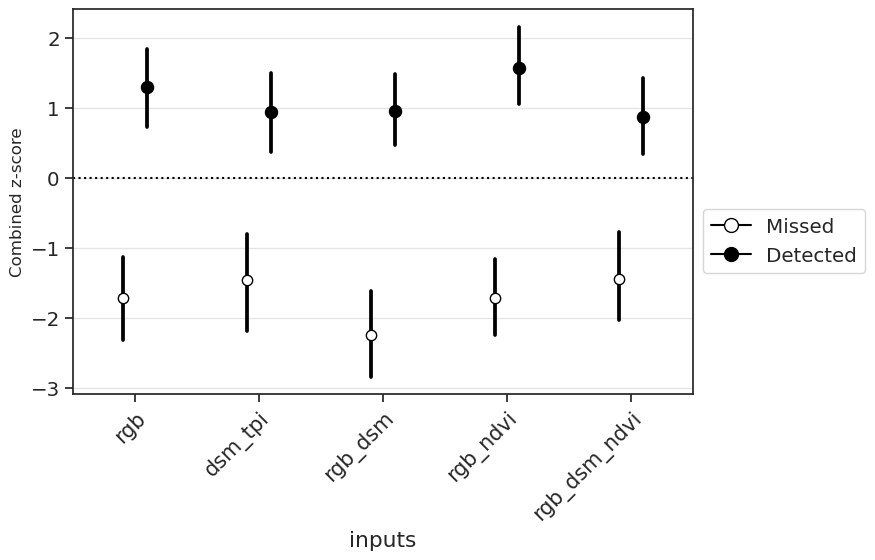

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
df_burrow_gt_std['score'] = df_burrow_gt_std.apply(lambda x: x['height'] + x['size'] + x['activity'] + (-1.0 * x['vegetation']), axis=1)
sns.pointplot(x='inputs', y='score', data=df_burrow_gt_std.sort_values(['n_inputs', 'inputs']),
            hue='pred', ax=ax, dodge=0.2, join=False, ci=99, markers='o', scale=1.1, 
              palette={0.0: 'black', 1.0: 'black'}, fc=['white', 'black'], ec=['black', 'none'])
ax.legend().remove()
ax.axhline(y=0, linestyle='dotted', color='black')
p1=ax.get_children()[5]
p1.set_facecolor('white')
p1.set_linewidth(1)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=15)
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Missed',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]
ax.set_ylabel('Combined z-score', fontsize=12)
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.9, 0.0, 0.5, 0.5))
ax.grid(True, axis='y', alpha=0.5)
plt.savefig('./results_figs/missed_burrow_characteristics_zscore_comb.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [22]:
df_bbox_gt = df_bbox_gt[df_bbox_gt['Type'] != 'non_burrows'].copy()

In [23]:
def val_metrics(df, prefix='pred'):
    #(group_label, df) = grouping
    precision = df[prefix + '_correct_ct'].sum() / df[prefix + '_ct'].sum()
    recall = df[prefix + '_correct_ct'].sum() / df['gt_ct'].sum()
    fscore = (2 * precision * recall) / (precision + recall)
    return pd.DataFrame({'Precision': precision,
                         'Recall': recall,
                         'F-score': fscore},
                        index=[len(df.name.split('_'))])
#df_bbox.groupby('inputs').apply(val_metrics)

In [24]:
df_bbox_gt_pred_smry = df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby('inputs').apply(val_metrics).reset_index().rename(columns={'level_1': 'n_inputs'}).sort_values('n_inputs')
df_bbox_gt_label_smry = df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby('inputs').apply(val_metrics, prefix='label').reset_index().rename(columns={'level_1': 'n_inputs'}).sort_values('n_inputs')

In [25]:
df_bbox_gt_label_smry.round(2)

,inputs,n_inputs,Precision,Recall,F-score
1,rgb,1,0.81,0.74,0.77
0,dsm_tpi,2,0.81,0.74,0.77
2,rgb_dsm,2,0.81,0.74,0.77
4,rgb_ndvi,2,0.81,0.74,0.77
3,rgb_dsm_ndvi,3,0.81,0.74,0.77


In [26]:
len(df_bbox_gt[df_bbox_gt['Digitize'] == 1]['Tile'].unique())

13

In [27]:
df_bbox_gt_pred_smry.round(2)

,inputs,n_inputs,Precision,Recall,F-score
1,rgb,1,0.72,0.63,0.67
0,dsm_tpi,2,0.79,0.66,0.72
2,rgb_dsm,2,0.82,0.80,0.81
4,rgb_ndvi,2,0.71,0.57,0.64
3,rgb_dsm_ndvi,3,0.78,0.67,0.72
